## Summary:
**Name:** Functionalize EnKF  
**Author:** Siyang Jing  
**Organization:** UNC-CH  
**License:** WTFPL  

**Reference:**
1. Amit Apte's EnKF code in Python
1. Christian Sampson's EnKF code in matlab
1. The author's other codes
1. Relevant numerous papers
  
**Description:**  
This file prepares a function EnKF based on Full_EnKF.ipynb.  
_Input_:
* Parameters: (To be implemented)
  * ndim: dimension of state space default is 40,
  * pars: parameters for model ode, default value is (8.0) for Lorenz 96,
  * nobs: number of observations, dafault is 50,
  * deltaobs=0.1,
  * dobs=None,
  * Hmat=None,
  * sigmaobs=0.9,
  * infl_lin=0.5,
  * infl_nlin=1,
  * sigmainit=1.3,
  * nens=100,
  * ferr=1.0
* DA Flags: (To be implemented)
  * HTYPE: type of observation operator
    * None: everything is specified in parameters, **TODO**
    * 0: ObsOp_40_20
    * 1: ObsOp_40_20 with Inv_20_10
  * LINEAR: whether to use linearized KF or not, specific to $H$
  * HERROR: whether H and Hm are the same
* Usage Flags: (To be implemented)
  * PLOTTING
  * DEBUG
  * SAVEDATA: indicator for which data to save  
    * 0: Don't save anything
    * 1: Save everything including,  
      1. Flags and Parameters  
      1. xfm, xam, xfcov, xacov  
      1. yfm, yfcov  
      1. statistics  
    * 2: Flags, Paramters, Statistics (No running data)
    * 3: haha
  
_Output_:  
Forecast/analysis absolute error averaged over variables and time (from the 30th observation step as the starting point after DA stabilizes)
1. xferravgxt: forecast absolute error averaged over all variables and time
1. xaerravgxt: analysis absolute error averaged over all variables and time
1. xferr10avgxt: forecast absolute error averaged over first 10 variables and time
1. xaerr10avgxt: analysis absolute error averaged over first 10 variables and time
1. xferr30avgxt: forecast absolute error averaged over last 30 variables and time
1. xaerr30avgxt: analysis absolute error averaged over last 30 variables and time

_Saved Files_:   
Variables saved in a .npz file with their orginal names with numpy.savez method.  

_Plots_:
1. Long true trajectory
1. Run results
1. Statistics

**Requirements:**
1. Relevant Python modules
1. AuxFuncs, which defines the following:  
  1. Observation operator  
  1. Stupid inverse function  
  1. Lorenz96 as model

## TODO list:
1. Improve the saving procedure
1. Write own RK4, standardize the model forward step
1. Write as a function this file
1. Implement pipeline

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy as scp
import scipy.integrate

import AuxFuncs

In [72]:
def EnKF(
    #### Paramters
    ## Notebook usage flags
    RSEED = 215,
    HTYPE = 0,
    PLOTTING = False,
    LINEAR = False,
    Hmat=None,
    FORECAST_ERROR = True,
    HERROR = False,
    INFLATION = True,
    DEBUG = False,
    SAVEDATA = 0,
    data_dir = None,
    DESC = 'Data',
    ## Model parameters
    ndim = 40,
    pars = (8.0),
    ## Observation paramters
    nobs=50,
    deltaobs=0.1,
    dobs=None,
    H=None,Hm=None,
    # Suggested value
    # Could also choose from long trajectory
    sigmaobs=0.9,

    ## DA paramters
    infl_lin=0.5,
    infl_nlin=1,
    sigmainit=1.3,
    nens=100,
    ferr=1.0):
    
    np.random.seed(RSEED)
    
    # True model
    def TM(xin,tin,pars):
        return AuxFuncs.l96rhs(xin,tin,pars)

    # Forcast model
    def TF(xin,tin,pars):
        return AuxFuncs.l96rhs(xin,tin,pars)

    # Potentially different to introduce model error

    if HTYPE==1 or (LINEAR and Hmat is None):
        if dobs is None:
            dobs = 10
        Hmat = np.zeros([dobs,ndim])
        for i in np.arange(dobs):
            Hmat[i,i] = 1.0            
            
    if HTYPE is None:
        ## TODO
        if HERROR and Hm is None:
            ## TODO
            Hm = H
    elif HTYPE==0:
        ## Setting for direct observation
        
        dobs = 20
        # True observation operator
        def H(x):
            return AuxFuncs.ObsOp_40_20(x)
        # The observation operator that we think is true
        def Hm(x):
            return AuxFuncs.ObsOp_40_20(x)
        
    elif HTYPE==1:
        ## Setting for stupid inversion case
        
        dobs = 10

        # True observation operator
        def H(x):
            return AuxFuncs.Inv_20_10(AuxFuncs.ObsOp_40_20(x))

        # The observation operator that we think is true
        def Hm(x):
            if not HERROR:
                return H(x)
            return Hmat @ x        

    ## find an initial condition on the attractor

    xrand = np.random.rand(ndim)
    ttrans = np.linspace(0,100,1000)
    xtrans = scp.integrate.odeint(TM, xrand, ttrans, (pars,))

    t = np.linspace(0,50,100000)
    xattr = xtrans[-1,:]

    ## plot a long trajectory...

    tlong = np.linspace(0,100,10000)
    xlong = scp.integrate.odeint(TM, xattr, tlong, (pars,))

    if PLOTTING:
        # Plotting
        plt.figure(figsize=(10, 8))
        plt.imshow(xlong, aspect='auto')
        plt.colorbar()

    #sigmaobs = np.abs(np.max(xlong[:,0]) - np.min(xlong[:,0]))/50


    ## generate true trajectory

    tend = nobs * deltaobs
    tobs = np.linspace(0, tend, num=nobs+1)
    ttraj = np.linspace(0, tend, num=nobs*100+1)
    truetraj = scp.integrate.odeint(TM, xattr, ttraj, (pars,))
    truestate = truetraj[::100,:]

    truestate = truestate.T

    ## generate observations

    trueobs = H(truestate)
    robs = sigmaobs*sigmaobs
    Robsmat = np.identity(dobs)*robs
    yobs = trueobs + np.random.multivariate_normal(np.zeros(dobs), Robsmat,nobs+1).T



    sigmainit = sigmaobs*10

    ## Containers
    xfm = np.zeros([nobs+1, ndim])
    xam = np.zeros([nobs+1, ndim])
    xfcov = np.zeros([nobs+1, ndim, ndim])
    xacov = np.zeros([nobs+1, ndim, ndim])

    yfm = np.zeros([nobs+1, dobs])
    yfcov = np.zeros([nobs+1, dobs, dobs])

    ## set the initial mean and covariance:
    xam[0,:] = xattr + sigmainit*np.random.randn(*xattr.shape)
    xacov[0,:,:] = np.identity(ndim)*sigmainit*sigmainit

    ## Generate initial ensemble
    xens = np.random.multivariate_normal(xam[0,:], xacov[0,:,:], nens)

    ## Iterate for each observation
    for ii in np.arange(1,nobs+1):

        ## Forecast
        for jj in np.arange(nens):
            xens[jj,:] = scp.integrate.odeint(TF, xens[jj,:], [tobs[ii-1], tobs[ii]], (pars,))[-1,:]
            if DEBUG:
                print('.',end='')
            if FORECAST_ERROR:
            # Introduce forecast model error
                xens[jj,:] += ferr * np.random.randn(ndim)

        ## Forecast mean and cov
        xfm[ii,:] = np.mean(xens,axis=0)
        xfcov[ii,:,:] = np.cov(xens.T)

        ## Observations generated from forecast
        ## Estimating the covariances with sample covariance
        yens = Hm(xens.T).T
        yfm[ii,:] = np.mean(yens,axis=0)
        yfcov[ii,:,:] = np.cov(yens.T)

        ## Kalman gain:
        if LINEAR:
        # Linear EnKF
            pf = xfcov[ii,:,:]

            if INFLATION:
            # inflation
                pf += infl_lin*np.trace(xfcov[ii,:,:])/ndim*np.identity(ndim)

            pfht = pf @ Hmat.T
            kgain = pfht @ np.linalg.pinv( Hmat @ pfht + Robsmat)

        else:
        # Nonlinear EnKF
            Ex = xens - xfm[ii,:]
            Ey = yens - yfm[ii,:]    
            Bxy = Ex.T @ Ey / (nens-1)
            Byy = yfcov[ii,:,:]

            if INFLATION:
            # Inflation
                Byy += infl_nlin*Robsmat
            kgain = Bxy @ np.linalg.pinv(Byy)

        ## Update ensemble members
        pertobs = np.random.multivariate_normal(yobs[:,ii],Robsmat,nens)

        for jj in np.arange(nens):
            xens[jj,:] += kgain @ (pertobs[jj,:] - Hm(xens[[jj],:].T).flatten())

        ## Analysis mean and cov
        xam[ii,:] = np.mean(xens,axis=0)
        xacov[ii,:,:] = np.cov(xens.T)

        if DEBUG:
            print(ii)
    
    if PLOTTING:
        ## some plotting functions
        def plotwitherrorbarsobsplt(iob, itr, nsig, cvflag):
            lt, = plt.plot(ttraj, truetraj[:,itr])
            lf, = plt.plot(tobs[1:], xfm[1::,itr], '.-')
            la, = plt.plot(tobs, xam[:,itr], '.-')
            if cvflag:
                errf = np.sqrt(xfcov[:,itr,itr])*nsig
                plt.fill_between(tobs[1:], xfm[1:,itr] - errf[1:], xfm[1:,itr] + errf[1:], alpha=0.5, color = lf.get_color())
                erra = np.sqrt(xacov[:,itr,itr])*nsig
                plt.fill_between(tobs[1:], xam[1:,itr] - erra[1:], xam[1:,itr] + erra[1:], alpha=0.5, color = la.get_color())

        def plotwitherrorbarsnoobplt(itr, nsig, cvflag):
            lt, = plt.plot(ttraj, truetraj[:,itr])
            lf, = plt.plot(tobs[1:], xfm[1::,itr], '.-')
            la, = plt.plot(tobs, xam[:,itr], '.-')
            if cvflag:
                errf = np.sqrt(xfcov[:,itr,itr])*nsig
                plt.fill_between(tobs[1:], xfm[1:,itr] - errf[1:], xfm[1:,itr] + errf[1:], alpha=0.5, color = lf.get_color())
                erra = np.sqrt(xacov[:,itr,itr])*nsig
                plt.fill_between(tobs[1:], xam[1:,itr] - erra[1:], xam[1:,itr] + erra[1:], alpha=0.5, color = la.get_color())

        # For subplots
        def plotwitherrorbarsobsax(iob, itr, nsig, cvflag):
            lt, = ax.plot(ttraj, truetraj[:,itr])
            lf, = ax.plot(tobs[1:], xfm[1:,itr], '.-')
            la, = ax.plot(tobs[1:], xam[1:,itr], '.-')
            if cvflag:
                errf = np.sqrt(xfcov[:,itr,itr])*nsig
                ax.fill_between(tobs[1:], xfm[1:,itr] - errf[1:], xfm[1:,itr] + errf[1:], alpha=0.5, color = lf.get_color())
                erra = np.sqrt(xacov[:,itr,itr])*nsig
                ax.fill_between(tobs[1:], xam[1:,itr] - erra[1:], xam[1:,itr] + erra[1:], alpha=0.5, color = la.get_color())

        def plotwitherrorbarsnoobax(itr, nsig, cvflag):
            lt, = ax.plot(ttraj, truetraj[:,itr])
            lf, = ax.plot(tobs[1:], xfm[1:,itr], '.-')
            la, = ax.plot(tobs[1:], xam[1:,itr], '.-')
            if cvflag:
                errf = np.sqrt(xfcov[:,itr,itr])*nsig
                ax.fill_between(tobs[1:], xfm[1:,itr] - errf[1:], xfm[1:,itr] + errf[1:], alpha=0.5, color = lf.get_color())
                erra = np.sqrt(xacov[:,itr,itr])*nsig
                ax.fill_between(tobs[1:], xam[1:,itr] - erra[1:], xam[1:,itr] + erra[1:], alpha=0.5, color = la.get_color())


        ## plot observed variables
        cvflag = True

        nsig=3
        fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(13,7))
        for ii, ax in enumerate(axes.flat, start=1):
            iob = ii-1
            itr = iob
            plotwitherrorbarsobsax(iob, itr, nsig, cvflag)
            ax.grid()
        fig.tight_layout()

        ## plot some of the unobserved variables
        nsig=3
        fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(13,7))
        for ii, ax in enumerate(axes.flat, start=1):
            itr = ii + 20
            plotwitherrorbarsnoobax(itr, nsig, cvflag)
            ax.grid()
        fig.tight_layout()


        ## Plot truth, forecast, and analysis as images
        vmin=np.min((np.min(truestate),np.min(xfm),np.min(xam)))
        vmax=np.min((np.max(truestate),np.max(xfm),np.max(xam)))

        plt.figure(figsize=(17,6))
        plt.subplot(1,3,1)
        plt.imshow(truestate, aspect='auto', vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.subplot(1,3,2)
        plt.imshow(xfm.T, aspect='auto', vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.subplot(1,3,3)
        plt.imshow(xam.T, aspect='auto', vmin=vmin, vmax=vmax)
        plt.colorbar()

        ## Calculate statistics
        # Absolute errors
        xferr = np.abs(xfm - truestate.T)
        xaerr = np.abs(xam - truestate.T)

        vmin=np.min((np.min(xferr),np.min(xaerr)))
        vmax=np.min((np.max(xferr),np.max(xaerr)))

        plt.figure(figsize=(10,6))

        plt.subplot(1,2,1)
        plt.imshow(xferr[:,0:10], aspect='auto', vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.subplot(1,2,2)
        plt.imshow(xaerr[:,0:10], aspect='auto', vmin=vmin, vmax=vmax)
        plt.colorbar()
        
    
    ## Calculate statistics
    # Absolute errors
    xferr = np.abs(xfm - truestate.T)
    xaerr = np.abs(xam - truestate.T)
    
    xferr10 = xferr[:,0:10]
    xferr30 = xferr[:,10:]
    xaerr10 = xaerr[:,0:10]
    xaerr30 = xaerr[:,10:]

    xferr10avgx = np.mean(xferr10,axis=1)
    xaerr10avgx = np.mean(xaerr10,axis=1)

    xferr30avgx = np.mean(xferr30,axis=1)
    xaerr30avgx = np.mean(xaerr30,axis=1)

    xferravgx = np.mean(xferr,axis=1)
    xaerravgx = np.mean(xaerr,axis=1)

    avgstp = 30
    xferravgt = np.mean(xferr[avgstp:,:],axis=0)
    xferravgxt = np.mean(xferravgt)

    xaerravgt = np.mean(xaerr[avgstp:,:],axis=0)
    xaerravgxt = np.mean(xaerravgt)

    xferr10avgxt = np.mean(xferr10avgx)
    xaerr10avgxt = np.mean(xaerr10avgx)

    xferr30avgxt = np.mean(xferr30avgx)
    xaerr30avgxt = np.mean(xaerr30avgx)
    
    if PLOTTING:
        plt.figure()
        plt.subplot(1,3,1)
        plt.plot(xferr10avgx)
        plt.plot(xaerr10avgx)
        plt.legend(['forecast','analysis'])
        plt.title('First 10 variables')
        plt.subplot(1,3,2)
        plt.plot(xferr30avgx)
        plt.plot(xaerr30avgx)
        plt.legend(['forecast','analysis'])
        plt.title('Last 30 variables')
        plt.subplot(1,3,3)
        plt.plot(xferravgx)
        plt.plot(xaerravgx)
        plt.legend(['forecast','analysis'])
        plt.title('All variables')

        plt.figure()
        plt.plot(xferravgt)
        plt.plot(xaerravgt)
    
    '''
    SAVEDATA: indicator for which data to save  
      0: Don't save anything
      1: Save everything including,  
          1. Flags and Parameters  
          2. xfm, xam, xfcov, xacov  
          3. yfm, yfcov  
          4. statistics  
      2: Flags, Paramters, Statistics (No running data)
    '''
    if SAVEDATA==1:
        np.savez(data_dir,
                ## Paramters
                # Notebook usage flags
                DESC=DESC,
                RSEED=RSEED,
                HTYPE=HTYPE,
                HERROR=HERROR,
                LINEAR=LINEAR,
                FORECAST_ERROR=FORECAST_ERROR,
                INFLATION=INFLATION,
                # Model parameters
                ndim=ndim,
                pars=pars,
                # Observation paramters
                nobs=nobs,
                deltaobs=deltaobs,
                dobs=dobs,
                Hmat=Hmat,
                sigmaobs=sigmaobs,

                ## DA paramters
                infl_lin=infl_lin,
                infl_nlin=infl_nlin,
                sigmainit=sigmainit,
                nens=nens,
                ferr=ferr,
                 
                ## Running Data
                xfm=xfm,xfcov=xfcov,
                xam=xam,xacov=xacov,
                yfm=yfm,yfcov=yfcov,
                ## Statistics
                xferravgxt  =xferravgxt,  xaerravgxt  =xaerravgxt,
                xferr10avgxt=xferr10avgxt,xaerr10avgxt=xaerr10avgxt,
                xferr30avgxt=xferr30avgxt,xaerr30avgxt=xaerr30avgxt)
    elif SAVEDATA==2:
        np.savez(data_dir,
                ## Paramters
                # Notebook usage flags
                DESC=DESC,
                RSEED=RSEED,
                HTYPE=HTYPE,
                HERROR=HERROR,
                LINEAR=LINEAR,
                FORECAST_ERROR=FORECAST_ERROR,
                INFLATION=INFLATION,
                # Model parameters
                ndim=ndim,
                pars=pars,
                # Observation paramters
                nobs=nobs,
                deltaobs=deltaobs,
                dobs=dobs,
                Hmat=Hmat,
                sigmaobs=sigmaobs,

                ## DA paramters
                infl_lin=infl_lin,
                infl_nlin=infl_nlin,
                sigmainit=sigmainit,
                nens=nens,
                ferr=ferr,
                 
                ## Statistics
                xferravgxt  =xferravgxt,  xaerravgxt  =xaerravgxt,
                xferr10avgxt=xferr10avgxt,xaerr10avgxt=xaerr10avgxt,
                xferr30avgxt=xferr30avgxt,xaerr30avgxt=xaerr30avgxt)
    
    return (xferravgxt,   xaerravgxt,
            xferr10avgxt, xaerr10avgxt,
            xferr30avgxt, xaerr30avgxt)

....................................................................................................1
....................................................................................................2
....................................................................................................3
....................................................................................................4
....................................................................................................5
....................................................................................................6
....................................................................................................7
....................................................................................................8
....................................................................................................9
..................................................................................

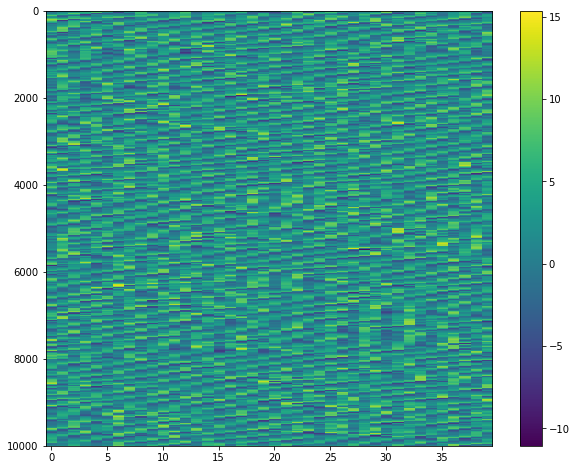

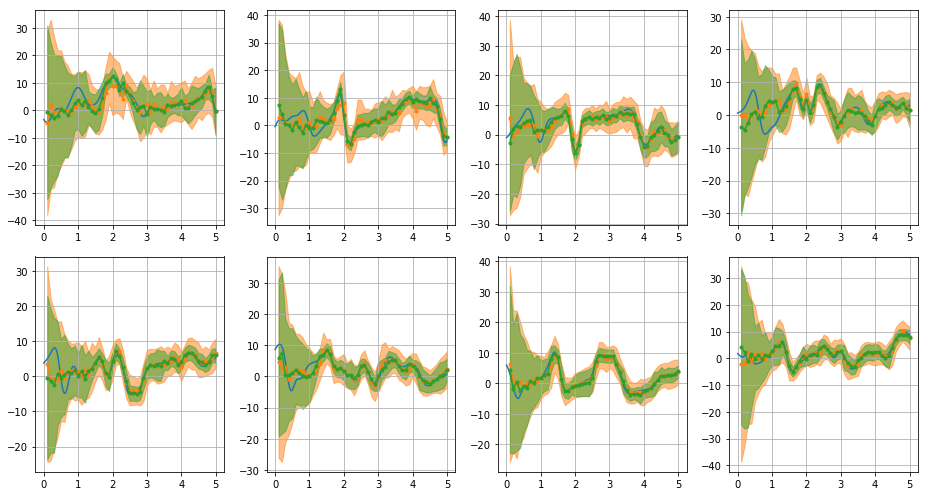

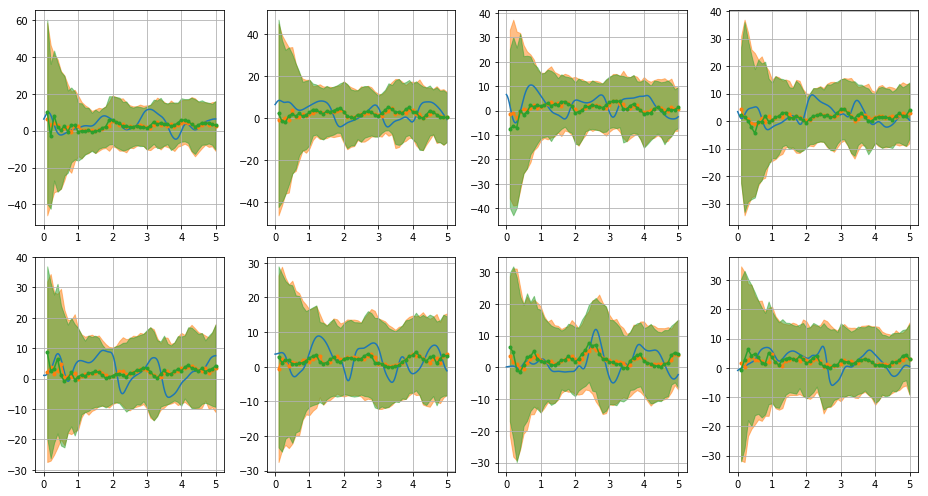

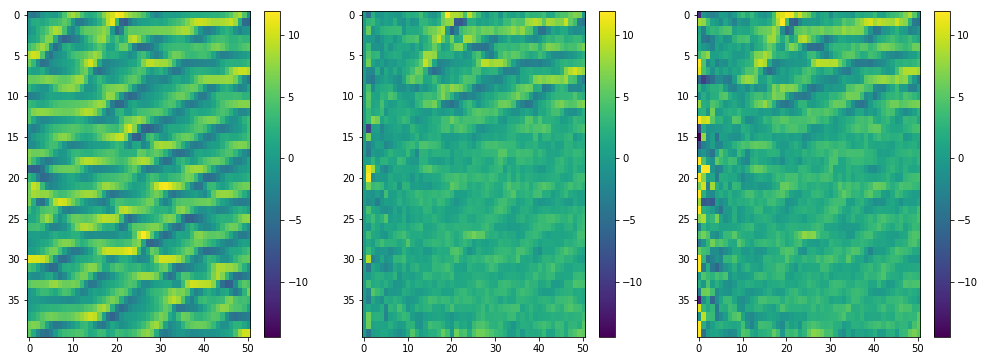

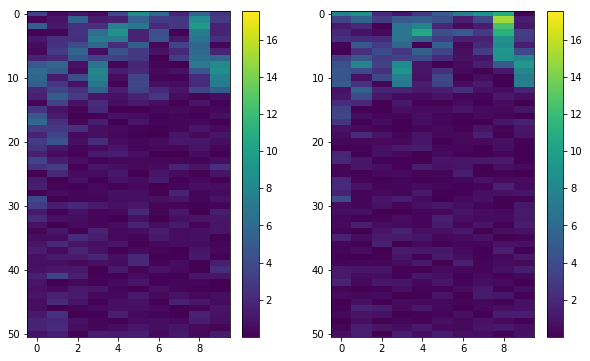

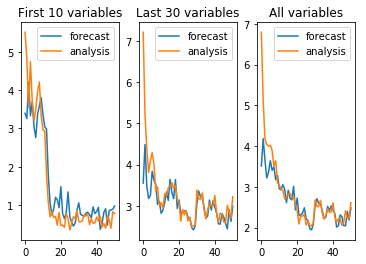

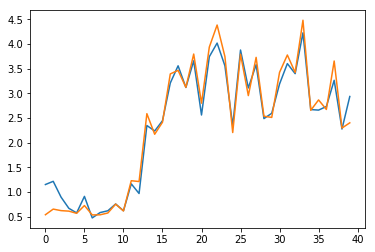

In [74]:
a,b,c,d,e,f=EnKF(RSEED=522,
                 HERROR=False,
                 LINEAR=False,
                 HTYPE=1,
                 SAVEDATA=1,data_dir='exp_dt1.npz',
                 DESC='experiment',
                 DEBUG=True,
                 PLOTTING=True)

In [75]:
print(a,b,c,d,e,f)

2.350119723655717 2.3592064869775577 1.4942002823412857 1.4159949000507004 3.032283306621987 3.2321089883006295


In [76]:
dt1 = np.load('exp_dt1.npz')

In [77]:
dt1

In [78]:
dt1.files

['DESC',
 'RSEED',
 'HTYPE',
 'HERROR',
 'LINEAR',
 'FORECAST_ERROR',
 'INFLATION',
 'ndim',
 'pars',
 'nobs',
 'deltaobs',
 'dobs',
 'Hmat',
 'sigmaobs',
 'infl_lin',
 'infl_nlin',
 'sigmainit',
 'nens',
 'ferr',
 'xfm',
 'xfcov',
 'xam',
 'xacov',
 'yfm',
 'yfcov',
 'xferravgxt',
 'xaerravgxt',
 'xferr10avgxt',
 'xaerr10avgxt',
 'xferr30avgxt',
 'xaerr30avgxt']

experiment
